In [3]:
import keras_tuner as kt
import numpy as np
import tensorflow as tf
from keras import layers
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.datasets import mnist, fashion_mnist

seed = 42
tf.keras.utils.set_random_seed(seed)
np.random.seed(seed)

# Blind source separation

This project aims to separate an image, formed as the sum of two images, into its original components.

The two source images, img1 and img2, are drawn from different datasets: MNIST and Fashion-MNIST, respectively.

No preprocessing is allowed. The neural network receives the combined image (img1 + img2) as input and outputs the predicted components (hat_img1,hat_img2).

Performance is evaluated using the mean squared error (MSE) between the predicted and ground-truth images.

Both datasets (MNIST and Fashion-MNIST) are grayscale. For simplicity, all samples are padded to a (32,32) resolution.

In [4]:
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
mnist_x_train, mnist_x_val, mnist_y_train, mnist_y_val = train_test_split(mnist_x_train, mnist_y_train, test_size=0.2)
print("mnist train shape:", np.shape(mnist_x_train))
print("mnist val shape:", np.shape(mnist_x_val))
print("mnist test shape:", np.shape(mnist_x_test))

(fashion_mnist_x_train, fashion_mnist_y_train), (fashion_mnist_x_test, fashion_mnist_y_test) = fashion_mnist.load_data()
fashion_mnist_x_train, fashion_mnist_x_val, fashion_mnist_y_train, fashion_mnist_y_val = train_test_split(fashion_mnist_x_train, fashion_mnist_y_train, test_size=0.2)
print("fashion mnist train shape:", np.shape(fashion_mnist_x_train))
print("fashion mnist val shape:", np.shape(fashion_mnist_x_val))
print("fashion mnist test shape:", np.shape(fashion_mnist_x_test))

#normalize in and pad
mnist_x_train = np.pad(mnist_x_train, ((0, 0), (2, 2), (2, 2))) / 255.
print(np.shape(mnist_x_train))
mnist_x_val = np.pad(mnist_x_val, ((0, 0), (2, 2), (2, 2))) / 255.
mnist_x_test = np.pad(mnist_x_test, ((0, 0), (2, 2), (2, 2))) / 255.

fashion_mnist_x_train = np.pad(fashion_mnist_x_train, ((0, 0), (2, 2), (2, 2))) / 255.
fashion_mnist_x_val = np.pad(fashion_mnist_x_val, ((0, 0), (2, 2), (2, 2))) / 255.
fashion_mnist_x_test = np.pad(fashion_mnist_x_test, ((0, 0), (2, 2), (2, 2))) / 255.

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
mnist train shape: (48000, 28, 28)
mnist val shape: (12000, 28, 28)
mnist test shape: (10000, 28, 28)
29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
fashion mnist train shape: (48000, 28, 28)
fashion mnist val shape: (12000, 28, 28)
fashion mnist test shape: (10000, 28, 28)
(48000, 32, 32)


In [5]:
print(np.shape(mnist_x_train))

(48000, 32, 32)


Here is a simple datagenerator.

In [6]:
def datagenerator(x1, x2, batchsize):
    n1 = x1.shape[0]
    n2 = x2.shape[0]
    while True:
        num1 = np.random.randint(0, n1, batchsize)
        num2 = np.random.randint(0, n2, batchsize)

        x_data = (x1[num1] + x2[num2]) / 2.0
        y_data = (x1[num1], x2[num2])

        yield x_data, y_data

Let us define a generator with batchsize=1 and let's test it.

In [7]:
onegen = datagenerator(mnist_x_test, fashion_mnist_x_test, 1)

Let us look at some input-output pairs

In [8]:
def show_images(x, y1, y2):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].imshow(x, cmap='gray')
    ax[0].title.set_text('Input')
    ax[0].axis('off')
    ax[1].imshow(y1, cmap='gray')
    ax[1].title.set_text('mnist')
    ax[1].axis('off')
    ax[2].imshow(y2, cmap='gray')
    ax[2].title.set_text('fashion_mnist')
    ax[2].axis('off')
    plt.show()

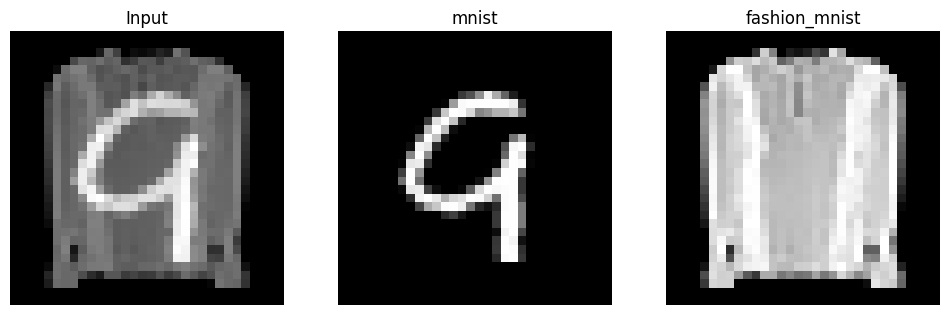

In [9]:
x, (y1, y2) = next(onegen)
show_images(x[0], y1[0], y2[0])

# Model evaluation

Let us define the test generator.

In [10]:
testgen = datagenerator(mnist_x_test, fashion_mnist_x_test, 5000)

eval_samples_x, (eval_samples_y1, eval_sample2) = next(testgen)

We test a model returning twice the input image. You will need to replace it with your own predictive model.

This model is designed to process input images and generate two separate outputs, each tailored for a different task (for example, predicting outputs for MNIST and Fashion MNIST). The model employs an encoder–decoder architecture with skip connections, which helps preserve both high-level and fine-grained features during the transformation process.

---

## 1. Input Processing

- **Input:**  
  The model accepts grayscale images of size 32×32. These images serve as the starting point for the feature extraction process.

---

## 2. Encoder: Feature Extraction and Downsampling

- **Feature Extraction:**  
  The encoder consists of several modules that apply a series of convolutional operations. Each module uses multiple convolutional layers (with a chosen activation function) to extract features from the input image. Batch normalization is used after each convolution to stabilize training and improve convergence.

- **Downsampling:**  
  After the convolutional operations in each module (except the final one), the feature maps are downsampled using pooling. This process reduces the spatial dimensions (e.g., from 32×32 to 16×16, then 8×8, etc.) while increasing the number of filters, thereby capturing more abstract representations of the input.

- **Skip Connections:**  
  At each encoder stage (except the bottleneck), the output feature maps are stored. These skip connections hold intermediate information that will be later fused with the upsampled features in the decoder, allowing the model to retain finer details that might otherwise be lost during downsampling.

---

## 3. Bottleneck

- **Deep Representation:**  
  At the deepest point of the encoder, the model captures the most abstract, high-level representation of the input. Although the spatial dimensions are reduced to a minimum, the feature richness is at its peak. This condensed representation serves as a bridge between encoding and decoding.

---

## 4. Decoder: Upsampling and Reconstruction

- **Upsampling:**  
  The decoder reverses the downsampling process. It uses transposed convolutions to gradually upsample the feature maps, increasing their spatial dimensions step by step.

- **Feature Fusion:**  
  As the decoder upsamples the features, it also reintroduces the stored skip connections from the encoder. By concatenating these skip features with the upsampled features, the network recovers detailed spatial information that was diminished during pooling. This fusion allows the decoder to produce more accurate and detailed reconstructions.

- **Refinement:**  
  After each upsampling step, additional convolutional layers refine the combined features. This helps in removing any artifacts from the upsampling process and in producing smoother, more consistent feature maps.

---

## 5. Dual-Output Branching

- **Shared Backbone:**  
  Up to the end of the decoder, both tasks share the same processing pipeline. The shared backbone ensures that the core features extracted from the input are leveraged by both tasks.

- **Branching into Two Heads:**  
  At the final stage of the decoder, the model splits into two separate branches. Each branch is designed to handle one of the tasks:
  
  - **Branch 1 (e.g., MNIST):**  
    This branch takes the shared features and processes them further using a final convolution to generate an output image. The output is reshaped to a 32×32 format.
  
  - **Branch 2 (e.g., Fashion MNIST):**  
    Similarly, this branch processes the shared features through its own final convolution and reshaping steps to produce an output image of the same size.

---

## 6. Training and Loss Computation

- **Loss Function:**  
  The model is trained using Mean Squared Error (MSE) as the loss function for both outputs. This loss measures the average squared difference between the predicted values and the actual target values.

- **Simultaneous Optimization:**  
  Since both branches share a common backbone but have distinct output layers, the training process optimizes both outputs concurrently. This dual-objective setup allows the network to learn features that are beneficial for both tasks while also adapting the final layers to the specific characteristics of each dataset.

- **Hyperparameter Tuning:**  
  The model incorporates hyperparameter tuning for key parameters such as the initial number of filters, the activation function, and the learning rate. This tuning helps in finding the optimal configuration for improved performance.

In [11]:
class MyHyperModel(kt.HyperModel):
    def __init__(self, input_shape=(32, 32, 1), total_modules=3, conv_layers_per_module=2):
        """
        Initializes the hypermodel with fixed architectural parameters.

        Args:
            input_shape: Shape of the input images.
            total_modules: Total number of encoder modules (including the bottleneck).
            conv_layers_per_module: Number of convolution layers in each module.
        """
        self.input_shape = input_shape
        self.total_modules = total_modules
        self.conv_layers_per_module = conv_layers_per_module

    def encoder_module(self, x, module_idx, filters, activation_fn):
        """
        Applies a block of convolutional operations and downsamples the feature maps.

        Args:
            x: Input tensor.
            module_idx: Current module index.
            filters: Number of convolution filters.
            activation_fn: Activation function to be used.

        Returns:
            A tuple (output_tensor, updated_filters).
        """
        for _ in range(self.conv_layers_per_module):
            x = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
            x = layers.BatchNormalization()(x)
            x = layers.Activation(activation_fn)(x)

        # Save output for skip connection if not in the bottleneck module.
        if module_idx < self.total_modules - 1:
            self.skip_connections.append(x)
            x = layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)
            filters *= 2
        return x, filters

    def decoder_module(self, x, module_idx, filters, activation_fn):
        """
        Upsamples the input, concatenates with the corresponding skip connection,
        and applies a block of convolutional operations.

        Args:
            x: Input tensor from the previous layer.
            module_idx: Current decoder module index.
            filters: Current number of filters.
            activation_fn: Activation function to be used.
        Returns:
            A tuple (output_tensor, updated_filters).
        """
        filters //= 2
        x = layers.Conv2DTranspose(filters, kernel_size=3, strides=2, padding='same')(x)
        # Use the last stored skip connection
        x = layers.concatenate([x, self.skip_connections.pop()])

        # Process with a convolutional block
        for _ in range(self.conv_layers_per_module):
            x = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
            x = layers.BatchNormalization()(x)
            x = layers.Activation(activation_fn)(x)
        return x, filters

    def build(self, hp):
        """
        Constructs and compiles the model based on hyperparameters defined via Keras Tuner.

        Hyperparameters tuned:
            - initial number of filters
            - activation function
            - learning rate

        Returns:
            A compiled Keras model with two outputs (each 32x32x1).
        """
        # Hyperparameter definitions
        init_filters = hp.Choice('initial_filters', values=[32, 64, 128], default=128)
        activation_fn = hp.Choice('activation_function', values=['relu', 'sigmoid', 'tanh', 'leaky_relu'], default='relu')
        lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

        # Input layer
        inputs = layers.Input(shape=self.input_shape)
        self.skip_connections = []
        x = inputs
        filters = init_filters

        # Encoder path
        for module in range(self.total_modules):
            x, filters = self.encoder_module(x, module, filters, activation_fn)

        # Decoder path (one fewer module than encoder)
        for module in range(self.total_modules - 1):
            x, filters = self.decoder_module(x, module, filters, activation_fn)

        # # Two separate output layers (1x1 convolutions) for two predictions
        output1 = layers.Conv2D(1, kernel_size=1, activation=activation_fn)(x)
        output1 = layers.Reshape((32, 32), name="MNIST_output")(output1)  # Ensure the final shape is (32, 32)
        output2 = layers.Conv2D(1, kernel_size=1, activation=activation_fn)(x)
        output2 = layers.Reshape((32, 32), name="Fashion_MNIST_output")(output2)  # Ensure the final shape is (32, 32)

        model = models.Model(inputs=inputs, outputs=[output1, output2])
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        model.compile(optimizer=optimizer, loss='mse', metrics=['mse', 'mse'])
        return model


# Instantiate the hypermodel.
hypermodel = MyHyperModel(input_shape=(32, 32, 1), total_modules=3, conv_layers_per_module=2)

### Setup of keras-tuner

In [12]:
# Set up the Keras Tuner using RandomSearch.
tuner = kt.RandomSearch(
    hypermodel,
    objective='val_loss',
    max_trials=50,
    executions_per_trial=1,
    directory='tuner_directory',
    project_name='model_tuning_project',
    seed=seed
)

### Hyperparameter tuning

In [ ]:
# Set the batch size for the data generators
batch_size = 32

# Create training and validation data generators
train_generator = datagenerator(mnist_x_train, fashion_mnist_x_train, batch_size)
val_generator = datagenerator(mnist_x_val, fashion_mnist_x_val, batch_size)

# Define early stopping callback to stop training when validation loss stops improving
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define learning rate reduction callback to reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Perform hyperparameter search using the defined tuner
tuner.search(
    train_generator,
    epochs=10,  # Initially keep the number of epochs low, can be increased later
    steps_per_epoch=len(mnist_x_train) // batch_size,
    validation_data=val_generator,
    validation_steps=len(mnist_x_val) // batch_size,
    callbacks=[early_stop, reduce_lr]
)

The results of the hyperparameter tuning are shown below, sorted by validation loss:

| activation_function | initial_filters | learning_rate | loss                  | val_loss              |
|---------------------|-----------------|---------------|-----------------------|-----------------------|
| relu                | 128             | 0.001         | 0.0014709887327626348 | 0.0013072943547740579 |
| relu                | 64              | 0.001         | 0.0014806203544139862 | 0.0014015233609825373 |
| relu                | 128             | 0.01          | 0.0016754703829064965 | 0.0014368335250765085 |
| relu                | 32              | 0.01          | 0.0016576856141909957 | 0.0014849023427814245 |
| relu                | 128             | 0.0001        | 0.0016250800108537078 | 0.0015756516950204968 |
| leaky_relu          | 128             | 0.001         | 0.0019190850434824824 | 0.001595867215655744  |
| relu                | 64              | 0.01          | 0.0018441571155562997 | 0.001627463148906827  |
| relu                | 64              | 0.0001        | 0.0018088191282004118 | 0.0017111394554376602 |
| relu                | 32              | 0.001         | 0.0017674821428954601 | 0.0017495471984148026 |
| leaky_relu          | 128             | 0.0001        | 0.0019855208229273558 | 0.0018404287984594703 |
| leaky_relu          | 128             | 0.01          | 0.0021171444095671177 | 0.0018492487724870443 |
| tanh                | 64              | 0.01          | 0.001917071989737451  | 0.0018555590650066733 |
| tanh                | 128             | 0.001         | 0.0021015035454183817 | 0.0018762836698442698 |
| sigmoid             | 128             | 0.01          | 0.001527645974420011  | 0.0018925678450614214 |
| leaky_relu          | 64              | 0.001         | 0.002121020806953311  | 0.0019129019929096103 |
| tanh                | 64              | 0.001         | 0.0021900697611272335 | 0.0019253080245107412 |
| tanh                | 128             | 0.0001        | 0.002129430416971445  | 0.0019433804554864764 |
| leaky_relu          | 64              | 0.01          | 0.002397720003500581  | 0.001972550293430686  |
| sigmoid             | 128             | 0.001         | 0.001849234919063747  | 0.0020385237876325846 |
| sigmoid             | 64              | 0.001         | 0.001959658693522215  | 0.002051526913419366  |
| leaky_relu          | 64              | 0.0001        | 0.002238338114693761  | 0.002068985253572464  |
| leaky_relu          | 32              | 0.001         | 0.0022017292212694883 | 0.0021118451841175556 |
| leaky_relu          | 32              | 0.01          | 0.0023894018959254026 | 0.002129998989403248  |
| sigmoid             | 32              | 0.001         | 0.002454108791425824  | 0.002279718406498432  |
| sigmoid             | 128             | 0.0001        | 0.0022045017685741186 | 0.002353810705244541  |
| tanh                | 32              | 0.01          | 0.0020146179012954235 | 0.0023821149952709675 |
| relu                | 32              | 0.0001        | 0.002656190423294902  | 0.0024807986337691545 |
| tanh                | 32              | 0.001         | 0.0026435016188770533 | 0.0025940979830920696 |
| tanh                | 64              | 0.0001        | 0.0029379650950431824 | 0.0027607246302068233 |
| tanh                | 128             | 0.01          | 0.002512458013370633  | 0.002886335365474224  |
| leaky_relu          | 32              | 0.0001        | 0.003389294957742095  | 0.0028948786202818155 |
| sigmoid             | 64              | 0.01          | 0.0020441189408302307 | 0.002991477958858013  |
| sigmoid             | 32              | 0.01          | 0.0020270845852792263 | 0.0031284161377698183 |
| sigmoid             | 64              | 0.0001        | 0.0030136341229081154 | 0.003595971968024969  |
| tanh                | 32              | 0.0001        | 0.004109883680939674  | 0.003725318470969796  |
| sigmoid             | 32              | 0.0001        | 0.0038146767765283585 | 0.003922066651284695  |


If you don't want to train the model, you can skip this section and load the pre-trained model in the following section.

Just download the model from the following link and load in yout project directory.

link : https://drive.google.com/drive/folders/1xSbRVtzoqzxR1g6U22gGWiE1_MDVKpif?usp=sharing



In [15]:
from tensorflow.keras.models import load_model
import json

best_model = load_model("my_best_model.h5", custom_objects={
    'mse': lambda y_true, y_pred: tf.keras.losses.MeanSquaredError()(y_true, y_pred)
})

with open("training_history.json", "r") as f:
    history = json.load(f)

### Model training
In this section the model with the best hyperparameters is trained.

Don't run this section if you have already downloaded the model.

In [ ]:
import json

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Best Initial Filters: {best_hps.get('initial_filters')}
Best Activation Function: {best_hps.get('activation_function')}
Best Learning Rate: {best_hps.get('learning_rate')}
""")

batch_size = 32
train_generator = datagenerator(mnist_x_train, fashion_mnist_x_train, batch_size)
val_generator = datagenerator(mnist_x_val, fashion_mnist_x_val, batch_size)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Build best model
best_model = tuner.hypermodel.build(best_hps)

# Train best model with more epochs
history = best_model.fit(
    train_generator,
    epochs=100,  # Train longer on best configuration
    steps_per_epoch=len(mnist_x_train) // batch_size,
    validation_data=val_generator,
    validation_steps=len(mnist_x_val) // batch_size,
    callbacks=[early_stop, reduce_lr]
)

# Save the best model and training history
best_model.save("my_best_model.h5")

# After training your model and obtaining the history:
with open("training_history.json", "w") as f:
    json.dump(history.history, f)


Best Initial Filters: 128
Best Activation Function: relu
Best Learning Rate: 0.001

Epoch 1/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 181s 106ms/step - Fashion_MNIST_output_loss: 0.0141 - Fashion_MNIST_output_mse: 0.0141 - MNIST_output_loss: 0.0329 - MNIST_output_mse: 0.0329 - loss: 0.0469 - val_Fashion_MNIST_output_loss: 0.0025 - val_Fashion_MNIST_output_mse: 0.0025 - val_MNIST_output_loss: 0.0022 - val_MNIST_output_mse: 0.0022 - val_loss: 0.0048 - learning_rate: 0.0010
Epoch 2/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 162s 108ms/step - Fashion_MNIST_output_loss: 0.0023 - Fashion_MNIST_output_mse: 0.0023 - MNIST_output_loss: 0.0019 - MNIST_output_mse: 0.0019 - loss: 0.0041 - val_Fashion_MNIST_output_loss: 0.0014 - val_Fashion_MNIST_output_mse: 0.0014 - val_MNIST_output_loss: 0.0014 - val_MNIST_output_mse: 0.0014 - val_loss: 0.0029 - learning_rate: 0.0010
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 163s 108ms/step - Fashion_MNIST_output_loss: 0.0018 - Fashion_MNIST_output_mse: 0.0018 - MNIST_output_

I0000 00:00:1738866932.226328   29763 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4701 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:06:00.0, compute capability: 6.1
I0000 00:00:1738866941.341032   30078 service.cc:148] XLA service 0x7fea8c00a0a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738866941.341219   30078 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
I0000 00:00:1738866943.030451   30078 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1738866956.549192   30078 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [16]:
print(best_model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 128)    │          1,280 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 32, 128)    │            512 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 32, 32, 128)    │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 128)    │        147,584 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32, 32, 128)    │            512 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 32, 32, 128)    │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 16, 16, 128)    │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 16, 16, 256)    │        295,168 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 16, 16, 256)    │          1,024 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 16, 16, 256)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 16, 16, 256)    │        590,080 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 16, 16, 256)    │          1,024 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 16, 16, 256)    │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 8, 8, 256)      │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 8, 8, 512)      │      1,180,160 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 8,272,132 (31.56 MB)

 Trainable params: 8,267,010 (31.54 MB)

 Non-trainable params: 5,120 (20.00 KB)

 Optimizer params: 2 (12.00 B)

None


In [17]:
def eval_model(model):
    x, (y1, y2) = next(testgen)

    # Predict the output
    pred1, pred2 = model.predict(x)

    # return (np.mean((pred1-y1)**2) + np.mean((pred2-y2)**2) / 2)
    # corrected mean squared error calculation
    return (np.mean((pred1 - y1) ** 2) + np.mean((pred2 - y2) ** 2)) / 2

In this section, the evaluation of the model is done.

In [18]:
repeat_eval = 10  # Number of times to repeat the evaluation
eval_results = []  # List to store evaluation results
for i in range(repeat_eval):
    eval_results.append(eval_model(best_model))  # Evaluate the model and append the result to the list
print("mse = ", np.mean(eval_results))  # Print the mean of the evaluation results
print("standard deviation = ", np.std(eval_results))  # Print the standard deviation of the evaluation results

157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
mse =  0.00038570323155940207
standard deviation =  8.083142746987105e-06


In this section the history of the training is plotted. The history contains the mse and val_mse for each epoch.

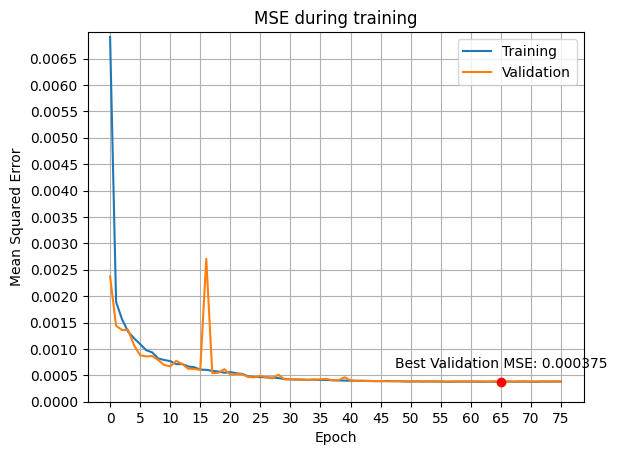

In [19]:
def display_history(history):
    # Check if the history is a dictionary, if not, convert it to a dictionary
    if not isinstance(history, dict):
        history = history.history

    # Extract MSE values for Fashion MNIST and MNIST from the history
    mse_fashion = history['Fashion_MNIST_output_mse']
    mse_mnist = history['MNIST_output_mse']

    # Calculate the mean MSE for each epoch
    mse_mean = [(a + b) / 2 for a, b in zip(mse_fashion, mse_mnist)]

    # Extract validation MSE values for Fashion MNIST and MNIST from the history
    mse_val_fashion = history['val_Fashion_MNIST_output_mse']
    mse_val_mnist = history['val_MNIST_output_mse']

    # Calculate the mean validation MSE for each epoch
    mse_val_mean = [(a + b) / 2 for a, b in zip(mse_val_fashion, mse_val_mnist)]

    # Plot the mean MSE and mean validation MSE
    plt.plot(mse_mean)
    plt.plot(mse_val_mean)
    plt.grid()

    # Set the title and labels for the plot
    plt.title('MSE during training')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')

    # Set the y-axis limits and ticks
    plt.ylim(0, 0.007)
    plt.yticks(np.arange(0.00000, 0.007, 0.0005))

    # Set the x-axis ticks
    plt.xticks(np.arange(0, 76, 5))

    # Highlight the best validation MSE
    best_epoch = np.argmin(mse_val_mean)
    plt.plot(best_epoch, mse_val_mean[best_epoch], 'ro')
    plt.annotate(f'Best Validation MSE: {mse_val_mean[best_epoch]:.6f}',
                 (best_epoch, mse_val_mean[best_epoch]),
                 textcoords="offset points",
                 xytext=(0, 10),
                 ha='center')

    # Add a legend to the plot
    plt.legend(['Training', 'Validation'])

    # Display the plot
    plt.show()


# Display the training history
display_history(history)

Real images:


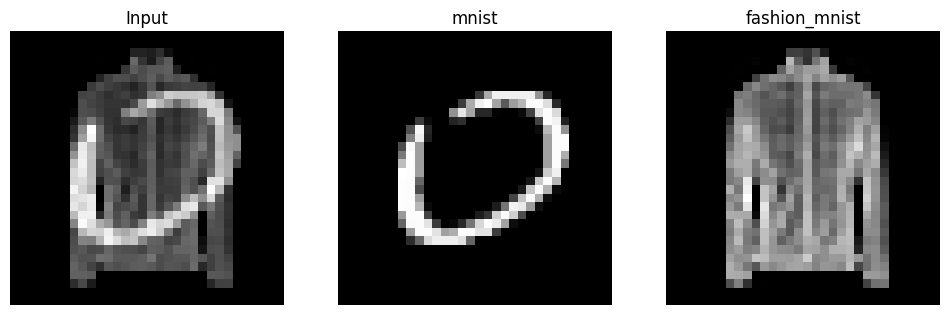

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted images:


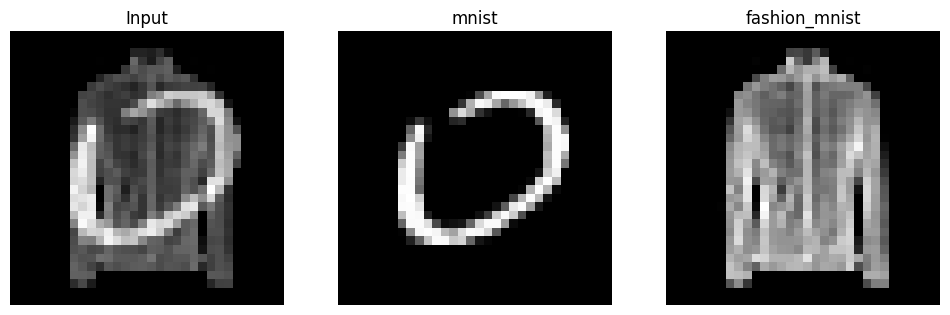



Real images:


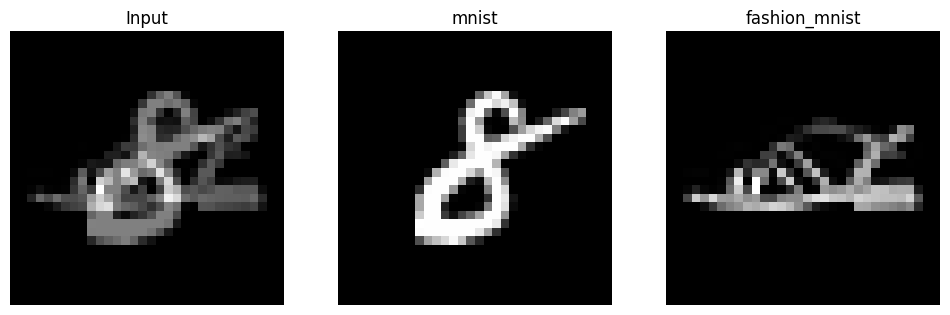

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted images:


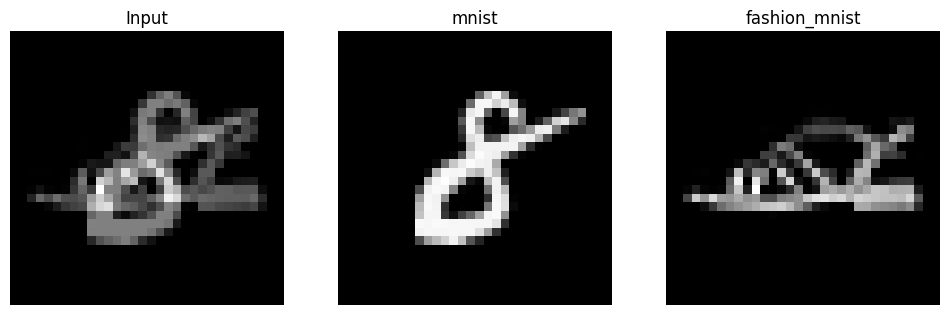



Real images:


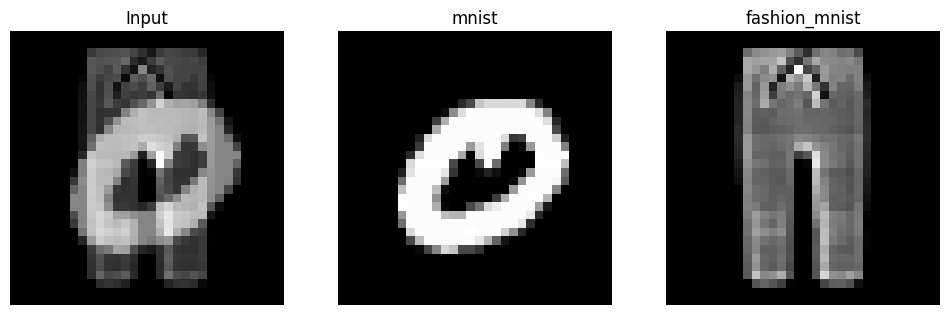

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted images:


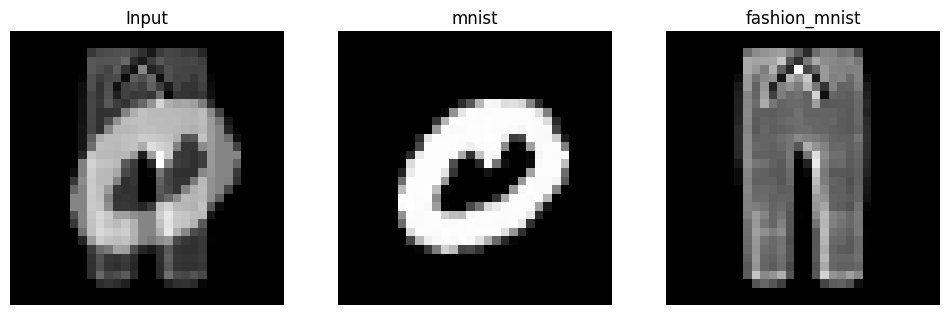



Real images:


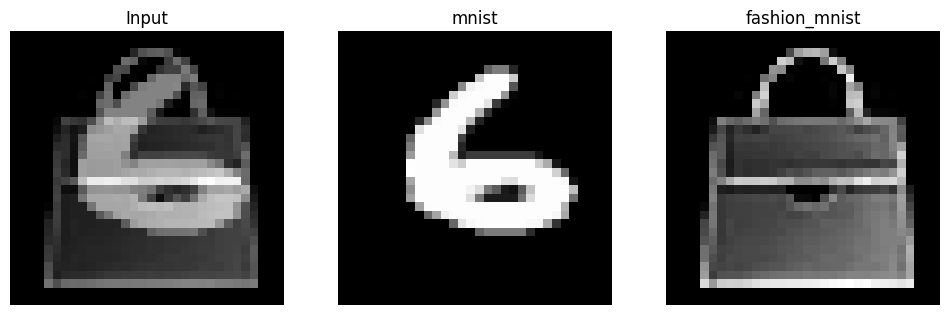

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted images:


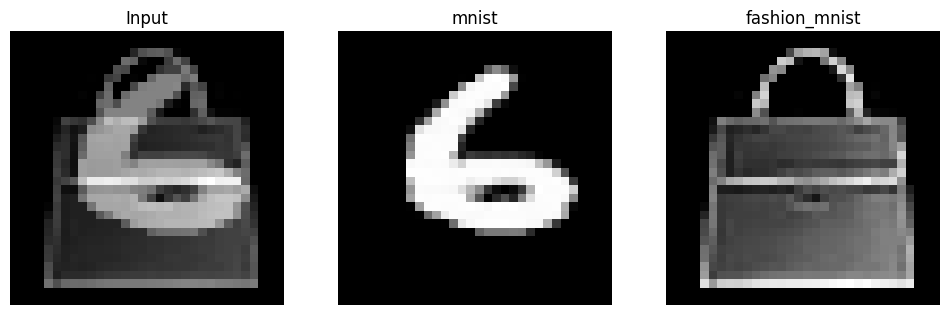



Real images:


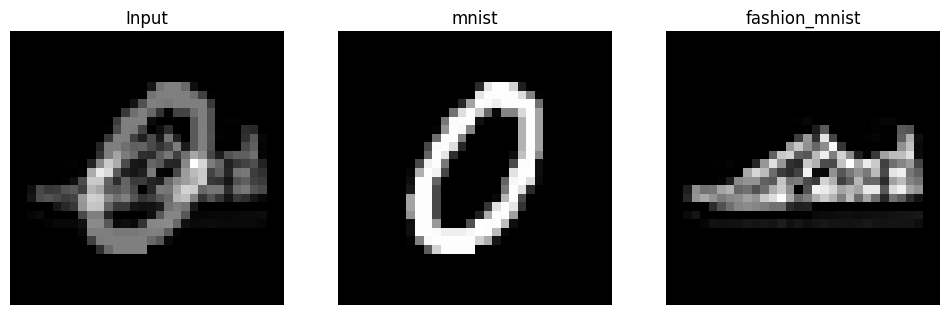

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted images:


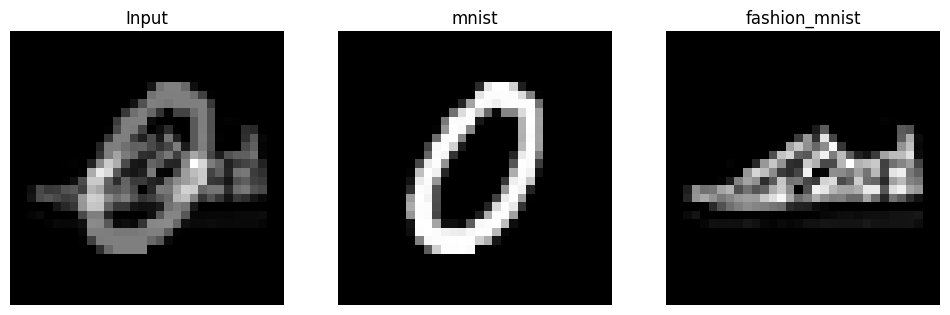



Real images:


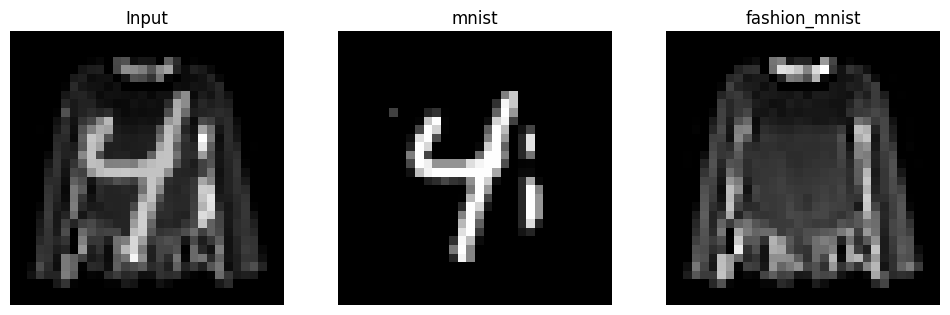

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted images:


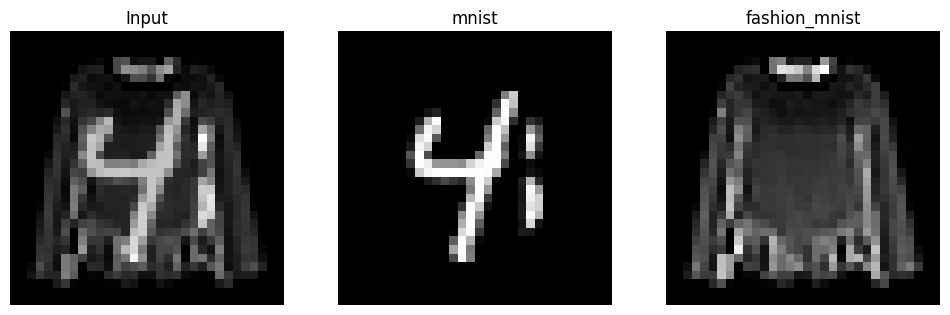



Real images:


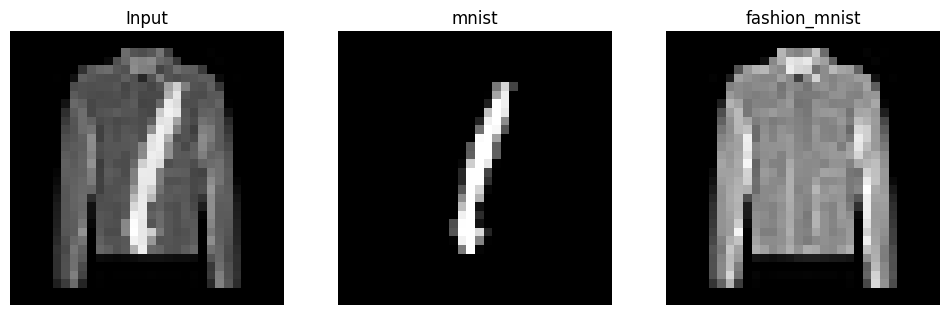

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted images:


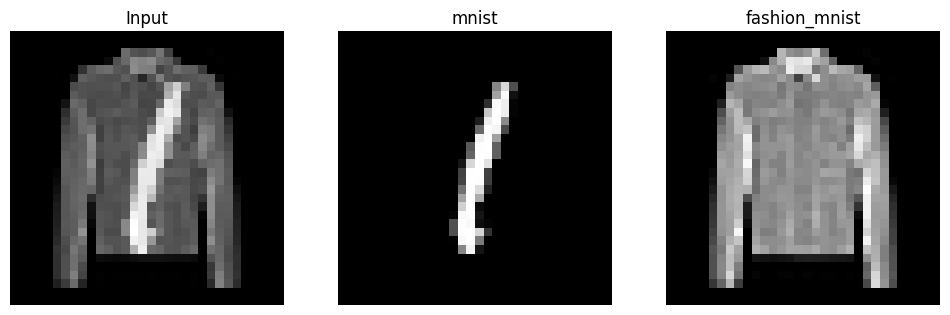



Real images:


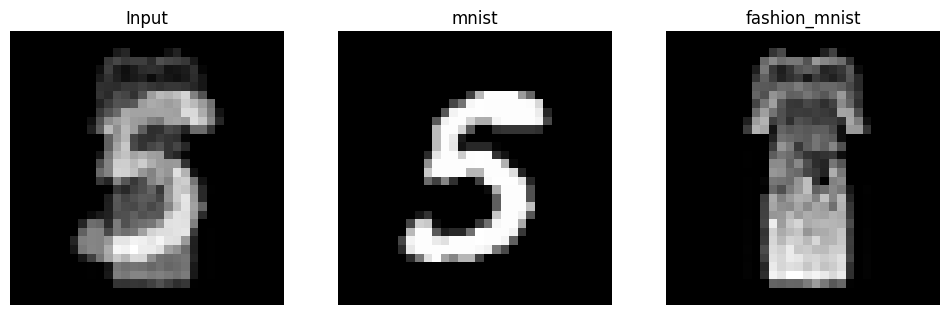

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted images:


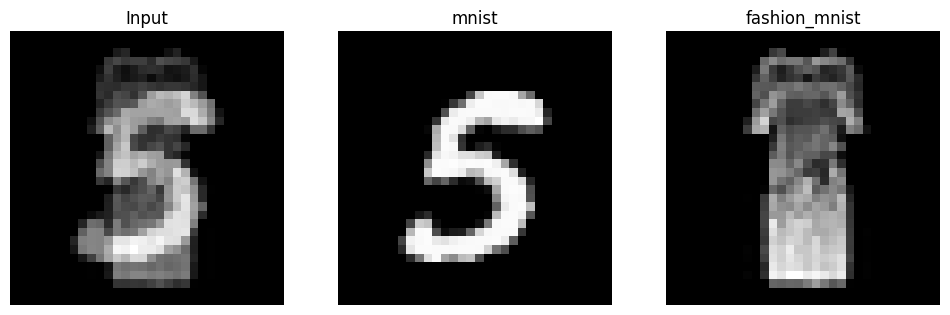



Real images:


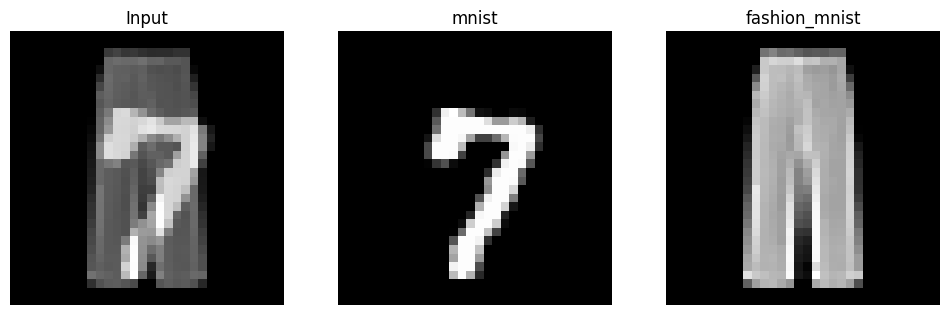

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted images:


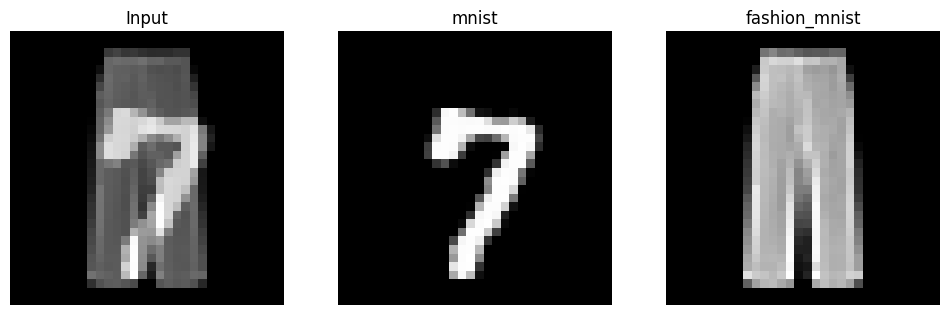



Real images:


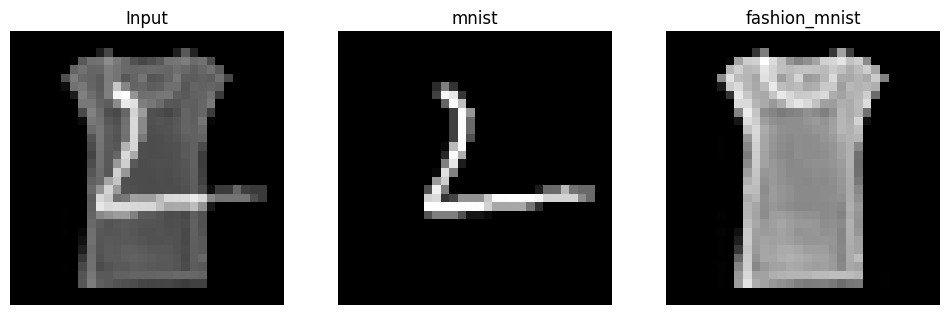

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Predicted images:


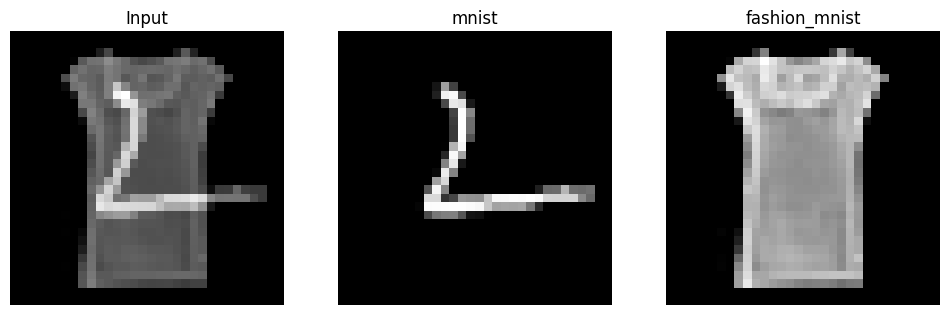

In [20]:
def display_image_predictions(generator, model, n_images=1):
    x_test, y_test = next(generator)

    for i in range(n_images):
        print(f'Real images:')
        show_images(x_test[i], y_test[0][i], y_test[1][i])

        # Get the prediction
        pred1, pred2 = model.predict(x_test[i][np.newaxis, ...])

        # Display the prediction
        print(f'Predicted images:')
        show_images(x_test[i], pred1[0], pred2[0])
        print('\n')

        plt.show()


display_image_predictions(testgen, best_model, n_images=10)